<div style="direction:rtl;line-height:300%;text-align:justify;" align="justify"><font face="B nazanin" size=4>
    <b style="font-size: 35px">خوشه‌بندی</b><br>
</font></div>

<div style="direction:rtl;line-height:300%;"><font face="XB Zar" size=3>
در این سوال قصد داریم دو الگوریتم kmeans و GMM را پیاده‌سازی کنیم. برای پیاده‌سازی این دو الگوریتم از کتابخانه‌های آماده پایتون که این دو الگوریتم در آن‌ها پیاده‌سازی شده‌اند استفاده نکنید. از این پیاده‌سازی در حل سوال‌های زیر استفاده کنید.

الگوریتم kmeans تا زمانی ادامه یابد که مرکز خوشه‌ها تغییر نکند و GMM نیز تا زمانی که اختلاف دو لگاریتم likelihood متوالی کمتر از 0.1 شود، ادامه یابد و مراکز اولیه GMM را مراکزی درنظر بگیرید که پس از اجرای الگوریتم kmeans به دست می‌آورید.
</font>
</div>

<div style="direction:rtl;line-height:200%;">
    <font face="XB Zar" size=3>
الف:
با استفاده از تابع زیر دیتاست را ایجاد کنید سپس با تعداد k=2 دو الگوریتم را روی دیتاست اجرا کنید. در روش k-means بهتر است الگوریتم را چندین بار با حالت های شروع مختلف اجرا کرده و بهترین نتیجه را انتخاب کنید.
    </font>
</div>

In [140]:
import math
import random
import numpy as np
import pandas as pd
import scipy.io as sio
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.special import comb
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix

In [186]:
from sklearn.datasets.samples_generator import make_classification
X,Y = make_classification(n_samples=700, n_features=10,
                           n_informative=5, n_redundant=0,
                           n_clusters_per_class=2, n_classes=3)

## Evaluation Metrics:

In [165]:
def purity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tot = len(y_pred)
    l = np.sum([np.max(i) for i in cm])
    return l / tot


def rand_index(y_true, y_pred):
    tp_fp = comb(np.bincount(y_true), 2).sum()
    tpfn = comb(np.bincount(y_pred), 2).sum()
    A = np.c_[(y_true, y_pred)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum() for i in set(y_true))
    fp = tp_fp - tp
    fn = tpfn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

## K-Means:

In [187]:
class K_Means:
    def __init__(self, k=2, max_iter=100):
        self.k = k
        self.centroids = []
        self.max_iter = max_iter

    def fit(self,data):
        cs = np.random.choice(len(data), self.k, replace=False)
        self.centroids = data[cs]
        for i in range(self.max_iter):
            dists = cdist(data, self.centroids ,'euclidean')
            classifications = np.array([np.argmin(k) for k in dists])
            prev_centroids = np.copy(self.centroids)
            self.centroids = []
            for j in range(self.k):
                vs = classifications == j
                new_centroid = np.average(data[vs], axis=0)
                self.centroids.append(new_centroid)
            if (prev_centroids == self.centroids).all():
                return classifications
        return classifications 

    def predict(self,data):
        dists = cdist(data, self.centroids ,'euclidean')
        classifications = np.array([np.argmin(i) for i in dists])
        return classifications

In [189]:
best_score = 0
y_pred_final = []
for _ in range(10):   
    model = K_Means()
    Y_pred = model.fit(X)
    if purity(Y, Y_pred) > best_score:
        best_score = purity(Y, Y_pred)
        y_pred_final = Y_pred
print(best_score)
print(rand_index(Y, y_pred_final))

0.6257142857142857
0.5210259554465563


## GMM:

In [190]:
class GMM:
    def __init__(self, k, max_iter=100):
        self.k = k
        self.n = 0
        self.m = 0
        self.max_iter = max_iter
    
    def calc_log_likelihood(self, X):
        l = np.zeros((self.n, self.k))
        for i in range(self.k):
            p = multivariate_normal(mean=self.u[i], cov=self.sigma[i])
            l[:, i] = p.pdf(X)       
        n = l * self.phi
        tot = n.sum(axis=1)[:, np.newaxis]
        return n / tot

    def fit(self, X):
        self.n = X.shape[0]
        self.m = X.shape[1]
        self.phi = np.full(shape=self.k, fill_value=1 / self.k)
        self.w = np.full(shape=(self.n, self.m), fill_value=1 / self.k)      
        r = np.random.randint(low=0, high=self.n, size=self.k)
        self.u = [X[i,:] for i in r]
        self.sigma = [np.cov(X.T) for _ in range(self.k)]        
        for i in range(self.max_iter):
            self.w = self.calc_log_likelihood(X)
            if (i > 1) and np.fabs(self.w - old_w).all() < 1e-1:
                break
            self.phi = self.w.mean(axis=0)
            for i in range(self.k):
                w_ = self.w[:, [i]]
                total_weight = w_.sum()
                self.u[i] = (X * w_).sum(axis=0) / total_weight
                self.sigma[i] = np.cov(X.T, aweights=(w_/total_weight).flatten(), bias=True)
            old_w = self.w
    
    def predict(self, X):
        return np.argmax(self.calc_log_likelihood(X), axis=1)

In [193]:
gmm = GMM(k=2, max_iter=100)
gmm.fit(X)
y_gmm = gmm.predict(X)
print(purity(Y, y_gmm))
print(rand_index(Y, y_gmm))

0.6614285714285715
0.5484201921111792


<div style="direction:rtl;line-height:200%;">
    <font face="XB Zar" size=3>
ب:
        کیفیت الگوریتم‌های خوشه بندی پیاده سازی شده را با استفاده از روشهای Purity و Index - Rand بدست آورید و آنها را با هم مقایسه کنید.
    </font>
</div>

<div style="direction:rtl;line-height:200%;">
    <font face="XB Zar" size=3>
        پاسخ:
        دراکثر مواقع عملکرد GMM بهتر از K-means بوده اما به دلیل تصادفی بودن داده ها در بعضی موارد k-means عملکرد بهتری داشت که به دلیل متفاوت بودن داده ها در هر بار نظر قطعی نمیتوان داد
    </font>
</div>

<div style="direction:rtl;line-height:200%;">
    <font face="XB Zar" size=3>
ج:
        با استفاده از دستورات زیر دیتاست‌های جدید ایجاد کنید و دو الگوریتم را روی آن‌ها اجرا کنید و پس از بصری‌سازی با استفاده از کتابخانه‌های آماده پایتون، نتایج خوشه‌بندی را مقایسه کنید. 

از هر کتابخانه بصری‌سازی پایتون می‌توانید استفاده کنید. تعداد خوشه‌ها را برابر ۲ بگیرید.
    </font>
</div>

In [194]:
from sklearn.datasets.samples_generator import make_classification
X, Y = make_classification(n_samples=700, n_features=2,
                           n_informative=2, n_redundant=0,
                           n_classes=2)

### K-Means:

purity:
 0.7828571428571428
rand_index:
 0.6595299407316575


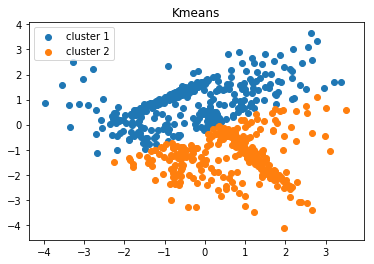

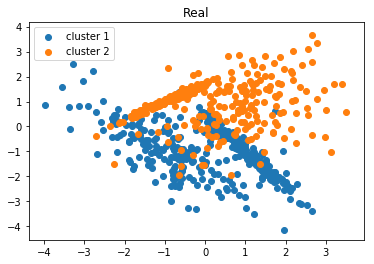

In [195]:
Y_pred = None
best_score = -100
for i in range(10):
    km = K_Means()
    Y_pred_new = km.fit(X)
    new_score = purity(Y, Y_pred_new)
    if new_score > best_score:
        best_score = new_score
        Y_pred = Y_pred_new

print("purity:\n", purity(Y, Y_pred)) 
print("rand_index:\n", rand_index(Y, Y_pred))
        
plt.scatter(X[Y_pred == 0, 0], X[Y_pred == 0, 1])
plt.scatter(X[Y_pred == 1, 0], X[Y_pred == 1, 1])
plt.title("Kmeans")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()


plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1])
plt.title("Real")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

### GMM:

purity:
 0.8414285714285714
rand_index:
 0.7327651747394237


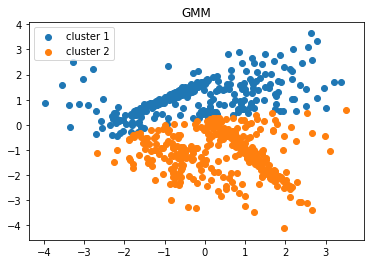

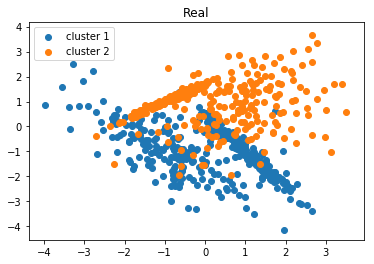

In [196]:
gmm = GMM(k=2, max_iter=100)
gmm.fit(X)
y_gmm = gmm.predict(X)

print("purity:\n", purity(Y, y_gmm)) 
print("rand_index:\n", rand_index(Y, y_gmm))

plt.scatter(X[y_gmm == 0, 0], X[y_gmm == 0, 1])
plt.scatter(X[y_gmm == 1, 0], X[y_gmm == 1, 1])
plt.title("GMM")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1])
plt.title("Real")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

In [179]:
from sklearn.datasets.samples_generator import make_moons
X, Y = make_moons(n_samples=700, noise=0.2)

### K-Means:

purity:
 0.7614285714285715
rand_index:
 0.636170038830983


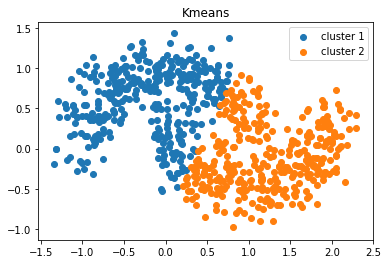

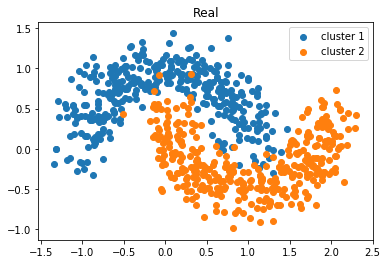

In [180]:
Y_pred = None
best_score = -100
for i in range(10):
    km = K_Means()
    Y_pred_new = km.fit(X)
    new_score = purity(Y, Y_pred_new)
    if new_score > best_score:
        best_score = new_score
        Y_pred = Y_pred_new
        
print("purity:\n", purity(Y, Y_pred)) 
print("rand_index:\n", rand_index(Y, Y_pred))
        
plt.scatter(X[Y_pred == 0, 0], X[Y_pred == 0, 1])
plt.scatter(X[Y_pred == 1, 0], X[Y_pred == 1, 1])
plt.title("Kmeans")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()


plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1])
plt.title("Real")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

### GMM:

purity:
 0.8528571428571429
rand_index:
 0.7486572654812998


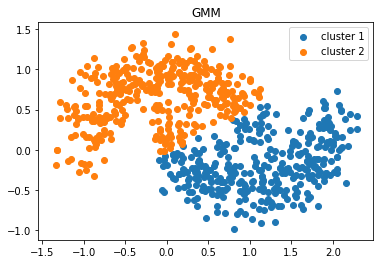

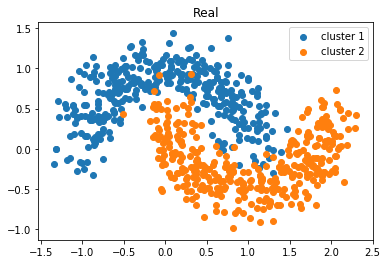

In [181]:
gmm = GMM(k=2, max_iter=100)
gmm.fit(X)
y_gmm = gmm.predict(X)

print("purity:\n", purity(Y, y_gmm)) 
print("rand_index:\n", rand_index(Y, y_gmm))

plt.scatter(X[y_gmm == 0, 0], X[y_gmm == 0, 1])
plt.scatter(X[y_gmm == 1, 0], X[y_gmm == 1, 1])
plt.title("GMM")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1])
plt.title("Real")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

In [182]:
from sklearn.datasets.samples_generator import make_circles
X, Y = make_circles(n_samples=700, noise=0.2)

### K-Means:

purity:
 0.5228571428571429
rand_index:
 0.4994318414060903


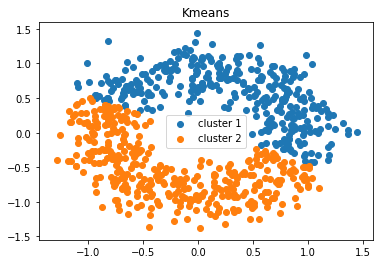

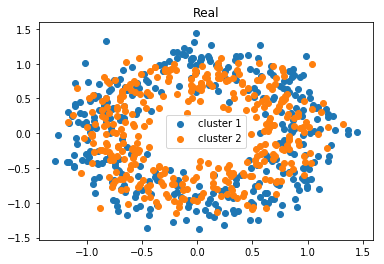

In [183]:
Y_pred = None
best_score = -100
for i in range(10):
    km = K_Means()
    Y_pred_new = km.fit(X)
    new_score = purity(Y, Y_pred_new)
    if new_score > best_score:
        best_score = new_score
        Y_pred = Y_pred_new
        
print("purity:\n", purity(Y, Y_pred)) 
print("rand_index:\n", rand_index(Y, Y_pred))

plt.scatter(X[Y_pred == 0, 0], X[Y_pred == 0, 1])
plt.scatter(X[Y_pred == 1, 0], X[Y_pred == 1, 1])
plt.title("Kmeans")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()


plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1])
plt.title("Real")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

### GMM:

purity:
 0.5614285714285714
rand_index:
 0.49977927651747395


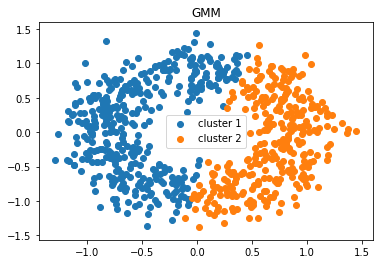

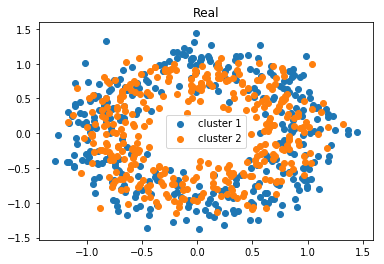

In [185]:
gmm = GMM(k=2, max_iter=100)
gmm.fit(X)
y_gmm = gmm.predict(X)

print("purity:\n", purity(Y, y_gmm)) 
print("rand_index:\n", rand_index(Y, y_gmm))

plt.scatter(X[y_gmm == 0, 0], X[y_gmm == 0, 1])
plt.scatter(X[y_gmm == 1, 0], X[y_gmm == 1, 1])
plt.title("GMM")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1])
plt.title("Real")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

<div style="direction:rtl;line-height:200%;">
    <font face="XB Zar" size=3>
        پاسخ:
        به طور کلی GMM عملکرد بهتری داشته همانطور که از اعداد مشخص است. اما در دو مثال آخر به دلیل اینکه داده ها جداپذیر خیلی نیستند این اعداد به طور کلی کمتر شده اند و به نسبت عملکرد خوبی نداشتند.
    </font>
</div>